# AMAZON PRODUCT Review - Sentiment Analysis

Analyzing the Amazon Alexa dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative.

### Importing required libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\disha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


### Exploratory Data Analysis

In [5]:
#Load the data
df = pd.read_csv(r"C:\Users\disha\Downloads\modified_reviews.csv")

df.head(4)

,Product_name,rating,review_title,review_discription
0,realme Buds Wireless 3 in-Ear Bluetooth Headph...,1.0,Ekdm bakwas,Very very bad
1,realme Buds Wireless 3 in-Ear Bluetooth Headph...,5.0,Good noise cancellation,Good bass and noise cancellation
2,realme Buds Wireless 3 in-Ear Bluetooth Headph...,5.0,Excellent 👌👌👌👌👌,Excellent product
3,realme Buds Wireless 3 in-Ear Bluetooth Headph...,1.0,Product seal was broken when received......sel...,The media could not be loaded.\n ...


In [6]:
df.head()

,Product_name,rating,review_title,review_discription
0,realme Buds Wireless 3 in-Ear Bluetooth Headph...,1.0,Ekdm bakwas,Very very bad
1,realme Buds Wireless 3 in-Ear Bluetooth Headph...,5.0,Good noise cancellation,Good bass and noise cancellation
2,realme Buds Wireless 3 in-Ear Bluetooth Headph...,5.0,Excellent 👌👌👌👌👌,Excellent product
3,realme Buds Wireless 3 in-Ear Bluetooth Headph...,1.0,Product seal was broken when received......sel...,The media could not be loaded.\n ...
4,realme Buds Wireless 3 in-Ear Bluetooth Headph...,4.0,"Overall worth my money,1200 (offer applied)",Decent performance!Slightly uncomfortable!


In [7]:
#Column names

print(f"Feature names : {df.columns.values}")

Feature names : ['Product_name' 'rating' 'review_title' 'review_discription']


In [8]:
#Check for null values

df.isnull().sum()

Product_name          0
rating                0
review_title          0
review_discription    0
dtype: int64

There is one record with no 'verified_reviews' (null value)

In [9]:
#Getting the record where 'verified_reviews' is null 

df[df['review_discription'].isna() == True]

,Product_name,rating,review_title,review_discription


In [10]:
#We will drop the null record

df.dropna(inplace=True)

In [11]:
print(f"Dataset shape after dropping null values : {df.shape}")

Dataset shape after dropping null values : (3067, 4)


In [12]:
# Combine 'review_title' and 'review_description' into a single text feature
df['review_text'] = df['review_title'] + " " + df['review_discription']

In [13]:
df.head(3)

,Product_name,rating,review_title,review_discription,review_text
0,realme Buds Wireless 3 in-Ear Bluetooth Headph...,1.0,Ekdm bakwas,Very very bad,Ekdm bakwas Very very bad
1,realme Buds Wireless 3 in-Ear Bluetooth Headph...,5.0,Good noise cancellation,Good bass and noise cancellation,Good noise cancellation Good bass and noise ca...
2,realme Buds Wireless 3 in-Ear Bluetooth Headph...,5.0,Excellent 👌👌👌👌👌,Excellent product,Excellent 👌👌👌👌👌 Excellent product


In [14]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

df['length'] = df['review_text'].apply(len)

In [15]:
df.head()

,Product_name,rating,review_title,review_discription,review_text,length
0,realme Buds Wireless 3 in-Ear Bluetooth Headph...,1.0,Ekdm bakwas,Very very bad,Ekdm bakwas Very very bad,25
1,realme Buds Wireless 3 in-Ear Bluetooth Headph...,5.0,Good noise cancellation,Good bass and noise cancellation,Good noise cancellation Good bass and noise ca...,56
2,realme Buds Wireless 3 in-Ear Bluetooth Headph...,5.0,Excellent 👌👌👌👌👌,Excellent product,Excellent 👌👌👌👌👌 Excellent product,33
3,realme Buds Wireless 3 in-Ear Bluetooth Headph...,1.0,Product seal was broken when received......sel...,The media could not be loaded.\n ...,Product seal was broken when received......sel...,180
4,realme Buds Wireless 3 in-Ear Bluetooth Headph...,4.0,"Overall worth my money,1200 (offer applied)",Decent performance!Slightly uncomfortable!,"Overall worth my money,1200 (offer applied) De...",86


The 'length' column is new generated column - stores the length of 'verified_reviews' for that record. Let's check for some sample records

In [16]:
#Randomly checking for 10th record

print(f"'review_text' column value: {df.iloc[10]['review_discription']}") #Original value
print(f"Length of review : {len(df.iloc[10]['review_discription'])}") #Length of review using len()
print(f"'length' column value : {df.iloc[10]['length']}") #Value of the column 'length'

'review_text' column value: As it is mentioned that i allows dual pairing but it doesnt support. User should make sure they are seeing for single pairing
Length of review : 125
'length' column value : 158


We can see that the length of review is the same as the value in the length column for that record

Datatypes of the features

In [17]:
df.dtypes

Product_name           object
rating                float64
review_title           object
review_discription     object
review_text            object
length                  int64
dtype: object

* rating, feedback and length are integer values <br>
* date, variation and verified_reviews are string values

### Analyzing 'rating' column

This column refers to the rating of the variation given by the user

In [18]:
len(df)

3067

In [19]:
#Distinct values of 'rating' and its count  

print(f"Rating value count: \n{df['rating'].value_counts()}")

Rating value count: 
5.0    1436
1.0     708
4.0     522
3.0     239
2.0     162
Name: rating, dtype: int64


Let's plot the above values in a bar graph

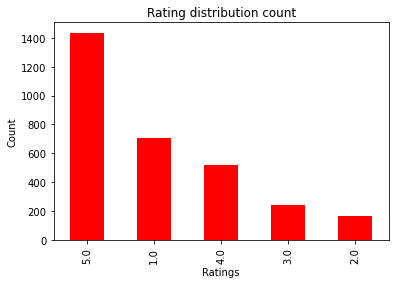

In [20]:
#Bar plot to visualize the total counts of each rating

df['rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [21]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records

print(f"Rating value count - percentage distribution: \n{round(df['rating'].value_counts()/df.shape[0]*100,2)}")

Rating value count - percentage distribution: 
5.0    46.82
1.0    23.08
4.0    17.02
3.0     7.79
2.0     5.28
Name: rating, dtype: float64


Let's plot the above values in a pie chart

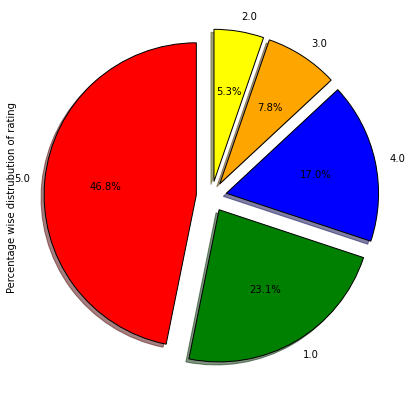

In [22]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = df['rating'].value_counts()/df.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

In [23]:
# Define the target variable based on the rating
def get_sentiment(rating):
    if rating > 3.0:
        return 1  # Positive sentiment
    elif rating == 3.0:
        return 0  # Neutral sentiment
    else:
        return -1  # Negative sentiment

In [24]:
df['Sentiment'] = df['rating'].apply(get_sentiment)

### Analyzing 'SENTIMENT' column

This column refers to the feedback of the verified review

In [25]:
df.head(4)

,Product_name,rating,review_title,review_discription,review_text,length,Sentiment
0,realme Buds Wireless 3 in-Ear Bluetooth Headph...,1.0,Ekdm bakwas,Very very bad,Ekdm bakwas Very very bad,25,-1
1,realme Buds Wireless 3 in-Ear Bluetooth Headph...,5.0,Good noise cancellation,Good bass and noise cancellation,Good noise cancellation Good bass and noise ca...,56,1
2,realme Buds Wireless 3 in-Ear Bluetooth Headph...,5.0,Excellent 👌👌👌👌👌,Excellent product,Excellent 👌👌👌👌👌 Excellent product,33,1
3,realme Buds Wireless 3 in-Ear Bluetooth Headph...,1.0,Product seal was broken when received......sel...,The media could not be loaded.\n ...,Product seal was broken when received......sel...,180,-1


In [26]:
df['Sentiment']

0      -1
1       1
2       1
3      -1
4       1
       ..
3062   -1
3063    1
3064    1
3065    0
3066    1
Name: Sentiment, Length: 3067, dtype: int64

In [27]:
#Distinct values of 'feedback' and its count 

print(f"sentiment value count: \n{df['Sentiment'].value_counts()}")

sentiment value count: 
 1    1958
-1     870
 0     239
Name: Sentiment, dtype: int64


There are 2 distinct values of 'feedback' present - 0 and 1. Let's see what kind of review each value corresponds to.

feedback value = 0

In [28]:
## Corrected code
review_0 = df[df['Sentiment'] == 0].iloc[1]['review_text']
print(review_0)


Sound quality is not good for me. I think it's sound quality is not so good as it claimed and the earphone does not fit in my ear.


In [29]:
#Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = df[df['Sentiment'] == 1].iloc[1]['review_text']
print(review_1)

Excellent 👌👌👌👌👌 Excellent product


From the above 2 examples we can see that feedback **0 is negative review** and **1 is positive review**

Let's plot the feedback value count in a bar graph

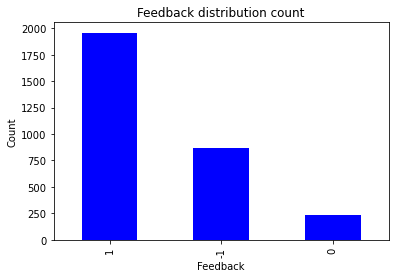

In [30]:
#Bar graph to visualize the total counts of each feedback

df['Sentiment'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [31]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records

print(f"Feedback value count - percentage distribution: \n{round(df['Sentiment'].value_counts()/df.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
 1    63.84
-1    28.37
 0     7.79
Name: Sentiment, dtype: float64


Feedback distribution <br>
* 91.87% reviews are positive <br>
* 8.13% reviews are negative

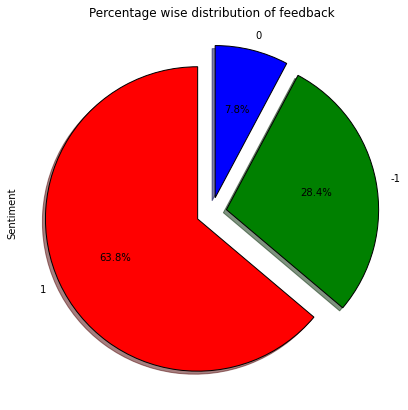

In [32]:
ig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue')  # Add more colors if necessary

wp = {'linewidth':1, "edgecolor":'black'}

tags = df['Sentiment'].value_counts()/df.shape[0]

explode = (0.1, 0.1, 0.1)  # Adjust this to match the number of unique sentiment values

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode)

plt.title('Percentage wise distribution of feedback')
plt.show()


Let's see the 'rating' values for different values of 'feedback'

In [33]:
#Feedback = 0
df[df['Sentiment'] == 0]['rating'].value_counts()

3.0    239
Name: rating, dtype: int64

In [34]:
#Feedback = 1
df[df['Sentiment'] == 1]['rating'].value_counts()

5.0    1436
4.0     522
Name: rating, dtype: int64

In [35]:
df[df['Sentiment'] == -1]['rating'].value_counts()

1.0    708
2.0    162
Name: rating, dtype: int64

### Analyzing 'variation' column

This column refers to the variation or type of Amazon Alexa product. Example - Black Dot, Charcoal Fabric etc.

In [36]:
#Finding the percentage distribution of each variation - we'll divide the number of records for each variation by total number of records

print(f"Variation value count - percentage distribution: \n{round(df['Product_name'].value_counts()/df.shape[0]*100,2)}")

Variation value count - percentage distribution: 
realme Buds Wireless 3 in-Ear Bluetooth Headphones,30dB ANC, Spatial Audio,13.6mm Dynamic Bass Driver,Upto 40 Hours Playback, Fast Charging, 45ms Low Latency for Gaming,Dual Device Connection (Black)    3.26
Harpic 1 Litre (Pack of 2) - Original, Disinfectant Toilet Cleaner Liquid | Suitable for Toilet Bowls                                                                                                      3.26
Dennis Lingo Men's Solid Dusty Pink Casual Shirt (C301_Dusty Pink_L)                                                                                                                                       3.26
3M Car wash Shampoo (250 ml) | High Foam for Deep Cleaning | Remove Tough Dirt | Safe on Paint | pH Neutral                                                                                                3.26
Amazon Brand - Presto! 2 Ply Kitchen Tissue/Towel Paper Roll 360 pulls | 60 pulls X 6 Rolls | soft and highly absorben

Mean rating according to variation

In [37]:
df.groupby('Product_name')['rating'].mean()

Product_name
3M Car Dashboard Dresser (250 ml) | Restores Gloss and Shine on Dashboard and Other Plastic Parts | Protection from UV Rays and Fading                                                                     4.070707
3M Car wash Shampoo (250 ml) | High Foam for Deep Cleaning | Remove Tough Dirt | Safe on Paint | pH Neutral                                                                                                4.150000
Allen Solly Men Jet Black Regular Fit Polo(AMKP317G04249_Jet Black_XL)                                                                                                                                     3.418367
Amazon Brand - Presto! 2 Ply Kitchen Tissue/Towel Paper Roll 360 pulls | 60 pulls X 6 Rolls | soft and highly absorbent | 100% Natural Virgin Cellulose Fiber                                              3.410000
Amazon Brand - Presto! Disinfectant Surface & Floor Cleaner, (Citrus) - 2 Ltr | Kills 99.9% Germs | Suitable for Bathroom & Floor surfaces 

Let's analyze the above ratings

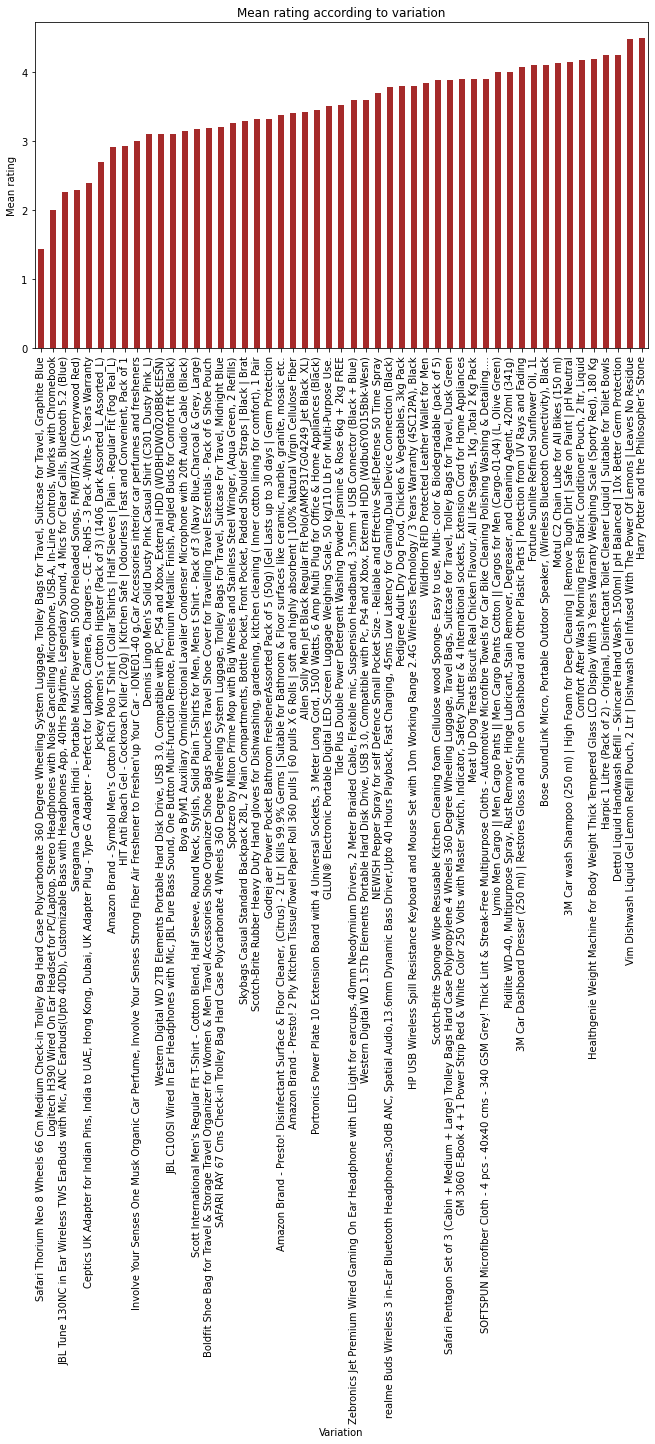

In [38]:
df.groupby('Product_name')['rating'].mean().sort_values().plot.bar(color = 'brown', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

### Analyzing 'review_text' column

This column contains the textual review given by the user for a variation for the product.

In [39]:
df['length'].describe()

count    3067.000000
mean       98.846104
std       131.556054
min         3.000000
25%        29.000000
50%        61.000000
75%       124.000000
max      2199.000000
Name: length, dtype: float64

Length analysis for full dataset

[Text(0.5, 1.0, 'Distribution of length of review ')]

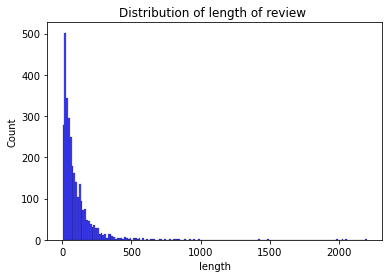

In [40]:
sns.histplot(df['length'],color='blue').set(title='Distribution of length of review ')

Length analysis when feedback is 0 (negative)

[Text(0.5, 1.0, 'Distribution of length of review if Sentiment = 0')]

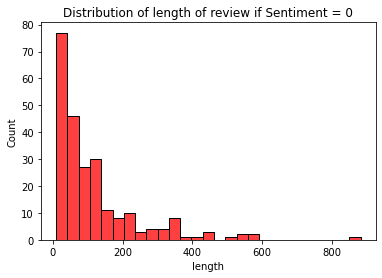

In [41]:
sns.histplot(df[df['Sentiment']==0]['length'],color='red').set(title='Distribution of length of review if Sentiment = 0')

Length analysis when feedback is 1 (positive)

[Text(0.5, 1.0, 'Distribution of length of review if sentiment = 1')]

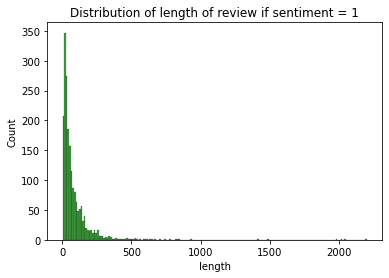

In [42]:
sns.histplot(df[df['Sentiment']==1]['length'],color='green').set(title='Distribution of length of review if sentiment = 1')

Lengthwise mean rating

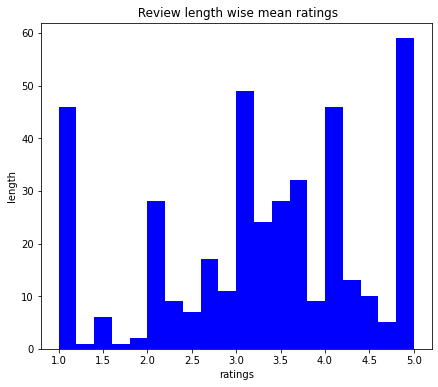

In [43]:
df.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [44]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df.review_text)

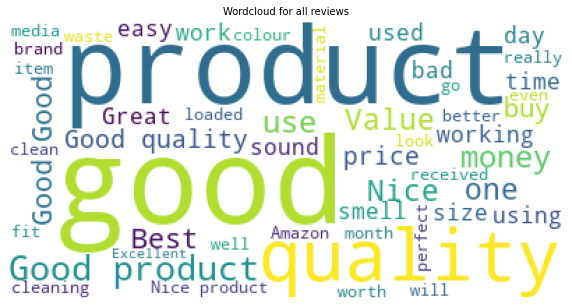

In [45]:
# Combine all reviews
reviews = " ".join([review for review in df['review_text']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

Lets find the unique words in each feedback category

In [46]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in df[df['Sentiment'] == -1]['review_text']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in df[df['Sentiment'] == 1]['review_text']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)


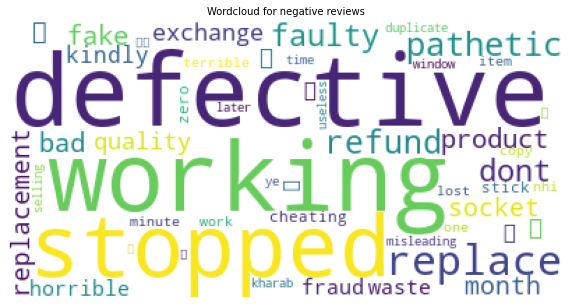

In [47]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

Negative words can be seen in the above word cloud - garbage, pointless, poor, horrible, repair etc

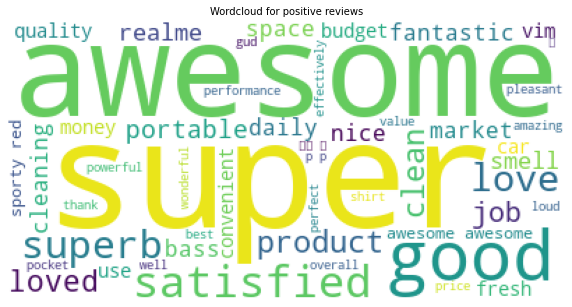

In [48]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

Positive words can be seen in the above word cloud - good, enjoying, amazing, best, great etc

# Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [49]:
df.head(3)

,Product_name,rating,review_title,review_discription,review_text,length,Sentiment
0,realme Buds Wireless 3 in-Ear Bluetooth Headph...,1.0,Ekdm bakwas,Very very bad,Ekdm bakwas Very very bad,25,-1
1,realme Buds Wireless 3 in-Ear Bluetooth Headph...,5.0,Good noise cancellation,Good bass and noise cancellation,Good noise cancellation Good bass and noise ca...,56,1
2,realme Buds Wireless 3 in-Ear Bluetooth Headph...,5.0,Excellent 👌👌👌👌👌,Excellent product,Excellent 👌👌👌👌👌 Excellent product,33,1


In [50]:
df.drop(['Product_name', 'review_title', 'review_discription'], axis=1, inplace=True)


In [51]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# Initialize stemmer and stop words
stemmer = PorterStemmer()
STOPWORDS = set(stopwords.words('english'))

In [52]:
df.head(3)

,rating,review_text,length,Sentiment
0,1.0,Ekdm bakwas Very very bad,25,-1
1,5.0,Good noise cancellation Good bass and noise ca...,56,1
2,5.0,Excellent 👌👌👌👌👌 Excellent product,33,1


In [53]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, df.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', df.iloc[i]['review_text'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

Using Count Vectorizer to create bag of words

In [58]:
from sklearn.feature_extraction.text import CountVectorizer

# Assuming 'text_column' is your feature column and 'label_column' is the target column in the dataframe df
cv = CountVectorizer(max_features=2500)

# Transforming the text data in 'text_column'
X = cv.fit_transform(df['review_text']).toarray()

# Assign the target variable to y
y = df['Sentiment'].values

# Checking the shape of X and y
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (3067, 2500)
y shape: (3067,)


In [59]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and cv = CountVectorizer(max_features=2500)
X_train = cv.fit_transform(df).toarray()

Checking the shape of X and y

In [60]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3067, 2500)
y shape: (3067,)


#Splitting data into train and test set with 30% data with testing.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2146, 2500)
y train: (2146,)
X test: (921, 2500)
y test: (921,)


In [62]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 20
X test max value: 24


We'll scale X_train and X_test so that all values are between 0 and 1.

In [63]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [66]:
import os
# Save scaler and vectorizer
os.makedirs('Models', exist_ok=True)
with open('Models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('Models/vectorizer.pkl', 'wb') as f:
    pickle.dump(cv, f)

In [67]:
import os
import pickle

# Ensure the directory exists
os.makedirs('Models', exist_ok=True)

# Save the scaler model
with open('Models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


#### Random Forest

In [68]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [69]:
# Save the model
with open('Models/model_rf.pkl', 'wb') as f:
    pickle.dump(model_rf, f)

In [70]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9920782851817335
Testing Accuracy : 0.8599348534201955


In [71]:
# Train the model
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [72]:
# Save the models and vectorizer
import os
os.makedirs('Models', exist_ok=True)

with open('Models/vectorizer.pkl', 'wb') as f:
    pickle.dump(cv, f)
with open('Models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('Models/model_rf.pkl', 'wb') as f:
    pickle.dump(model_rf, f)

print("Models and vectorizer have been saved.")

Models and vectorizer have been saved.


In [73]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [74]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

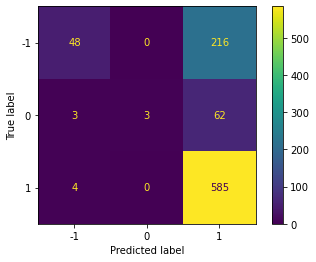

In [75]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [76]:
import os
import pickle
from sklearn.feature_extraction.text import CountVectorizer

# Assuming you have preprocessed the corpus and created the vectorizer
cv = CountVectorizer(max_features=2500)

# Ensure the directory exists
os.makedirs('Models', exist_ok=True)

# Save the vectorizer
with open('Models/vectorizer.pkl', 'wb') as f:
    pickle.dump(cv, f)


K fold cross-validation

In [77]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.8448598130841122
Standard Variance : 0.020708208120580593


Applying grid search to get the optimal parameters on random forest

In [78]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [79]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [80]:
#Getting the best parameters from the grid search


print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 100}


In [81]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 97.37884436160299
Cross validation mean accuracy on test set : 83.1663560111836
Accuracy score for test set : 0.6905537459283387


In [82]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

# Dummy setup for example
cv = CountVectorizer(max_features=2500)
scaler = MinMaxScaler()
model_rf = RandomForestClassifier()

# Save the models and vectorizer
os.makedirs('model_building/Models', exist_ok=True)

with open('model_building/Models/vectorizer.pkl', 'wb') as f:
    pickle.dump(cv, f)

with open('model_building/Models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('model_building/Models/model_rf.pkl', 'wb') as f:
    pickle.dump(model_rf, f)


In [83]:
# Save the vectorizer, scaler, and model
models_dir = 'model_buildings/Models'
os.makedirs(models_dir, exist_ok=True)

with open(os.path.join(models_dir, 'vectorizer.pkl'), 'wb') as f:
    pickle.dump(cv, f)

with open(os.path.join(models_dir, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

with open(os.path.join(models_dir, 'model_rf.pkl'), 'wb') as f:
    pickle.dump(model_rf, f)

print("Models and vectorizer have been saved.")

Models and vectorizer have been saved.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\disha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


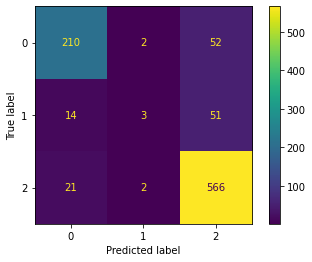

Accuracy: 0.8192110410780267
Standard Variance: 0.017754328788471933
Best Parameter Combination: {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 12, 'n_estimators': 300}
Cross validation mean accuracy on train set: 94.08783783783782
Cross validation mean accuracy on test set: 80.44617893755824
Accuracy score for test set: 0.8458197611292074


In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from wordcloud import WordCloud
import pickle
import re
import os

# Download stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

# Load the data
df = pd.read_csv(r"C:\Users\disha\Downloads\modified_reviews.csv")

# Combine 'review_title' and 'review_description' into a single text feature
df['review_text'] = df['review_title'] + " " + df['review_discription']

# Create a new column 'length' for the length of the review
df['length'] = df['review_text'].apply(len)

# Define the target variable based on the rating
def get_sentiment(rating):
    if rating > 3.0:
        return 1  # Positive sentiment
    elif rating == 3.0:
        return 0  # Neutral sentiment
    else:
        return -1  # Negative sentiment

df['Sentiment'] = df['rating'].apply(get_sentiment)

# Vectorize the text data
cv = CountVectorizer(stop_words='english', max_features=2500)
corpus = []
stemmer = PorterStemmer()

for i in range(df.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', df.iloc[i]['review_text'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

X = cv.fit_transform(corpus).toarray()
y = df['Sentiment'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

# Scaling
scaler = MinMaxScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

# Save scaler and vectorizer
os.makedirs('Models', exist_ok=True)
with open('Models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('Models/vectorizer.pkl', 'wb') as f:
    pickle.dump(cv, f)

# Train Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

# Save the model
with open('Models/model_rf.pkl', 'wb') as f:
    pickle.dump(model_rf, f)

# Predict and evaluate
y_preds = model_rf.predict(X_test_scl)
cm = confusion_matrix(y_test, y_preds)
ConfusionMatrixDisplay(cm).plot()
plt.show()

# Cross-validation
accuracies = cross_val_score(estimator=model_rf, X=X_train_scl, y=y_train, cv=10)
print("Accuracy:", accuracies.mean())
print("Standard Variance:", accuracies.std())

# Grid Search
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}
cv_object = StratifiedKFold(n_splits=2)
grid_search = GridSearchCV(estimator=model_rf, param_grid=params, cv=cv_object, verbose=0, return_train_score=True)
grid_search.fit(X_train_scl, y_train)
print("Best Parameter Combination:", grid_search.best_params_)
print("Cross validation mean accuracy on train set:", grid_search.cv_results_['mean_train_score'].mean() * 100)
print("Cross validation mean accuracy on test set:", grid_search.cv_results_['mean_test_score'].mean() * 100)
print("Accuracy score for test set:", accuracy_score(y_test, y_preds))


#### XgBoost

In [89]:
import numpy as np

# Replace -1 with 2 in y_train
y_train = np.where(y_train == -1, 2, y_train)

# Train the model
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [90]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.9254426840633737
Testing Accuracy : 0.6308360477741585


In [91]:
y_preds = model_xgb.predict(X_test)

In [92]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[  0   9  59 196]
 [  0  15  40  13]
 [  0   9 560  20]
 [  0   0   0   0]]


In [97]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))

#### Decision Tree Classifier

In [98]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [99]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9869524697110904
Testing Accuracy : 0.5874049945711184


In [100]:
y_preds = model_dt.predict(X_test)

In [101]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[  0  18  63 183]
 [  0  15  40  13]
 [  0  61 485  43]
 [  0   0   0   0]]


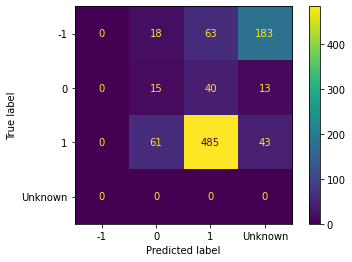

In [102]:
# Add an extra label to match the confusion matrix size
if len(unique_classes) < cm.shape[0]:
    unique_classes = np.append(unique_classes, 'Unknown')

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
cm_display.plot()
plt.show()


In [103]:
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk

# Download stopwords if not already done
nltk.download('stopwords')

# Initialize stemmer and stop words
stemmer = PorterStemmer()
STOPWORDS = set(stopwords.words('english'))

# Example text preprocessing
def preprocess_text(text):
    review = re.sub('[^a-zA-Z]', ' ', text)
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
    return ' '.join(review)

# Example usage
text = "I love this product, it's amazing!"
preprocessed_text = preprocess_text(text)
print(preprocessed_text)


love product amaz


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\disha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [104]:
# Save the vectorizer after fitting
with open('Models/vectorizer.pkl', 'wb') as f:
    pickle.dump(cv, f)


In [105]:
print(f"Vectorizer vocab size: {len(vectorizer.vocabulary_)}")


NameError: name 'vectorizer' is not defined